In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.optim as optim
import importlib
import inspect
import torch
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# preprocessing

In [6]:
df_half_hour=pd.read_csv('daily_max_temp_Riyadh.csv')
df_half_hour.isna().sum()

dwpf      0
relh      0
drct      0
sknt      0
alti      0
vsby      0
feel      0
temp_c    0
dtype: int64

In [7]:
daily_max_temp=df_half_hour
daily_max_temp

,dwpf,relh,drct,sknt,alti,vsby,feel,temp_c
0,39.2,34.80,320.0,18.0,30.09,6.21,68.00,20.0
1,33.8,26.43,330.0,6.0,30.18,6.21,69.80,21.0
2,42.8,31.34,170.0,3.0,30.15,6.21,73.89,24.0
3,24.8,14.37,170.0,6.0,30.12,6.21,75.08,25.0
4,35.6,23.66,0.0,0.0,30.06,6.21,73.53,24.0
...,...,...,...,...,...,...,...,...
5401,28.4,8.40,40.0,5.0,29.94,6.21,92.25,37.0
5402,21.2,6.57,150.0,5.0,29.91,6.21,90.11,36.0
5403,24.8,7.65,200.0,3.0,29.88,6.21,90.40,36.0
5404,30.2,9.04,80.0,4.0,29.91,6.21,92.46,37.0


In [8]:
percentile_90 = np.percentile(daily_max_temp['temp_c'], 90)
print(f"90th Percentile of max_temp_c: {percentile_90}")
daily_max_temp

90th Percentile of max_temp_c: 44.0


,dwpf,relh,drct,sknt,alti,vsby,feel,temp_c
0,39.2,34.80,320.0,18.0,30.09,6.21,68.00,20.0
1,33.8,26.43,330.0,6.0,30.18,6.21,69.80,21.0
2,42.8,31.34,170.0,3.0,30.15,6.21,73.89,24.0
3,24.8,14.37,170.0,6.0,30.12,6.21,75.08,25.0
4,35.6,23.66,0.0,0.0,30.06,6.21,73.53,24.0
...,...,...,...,...,...,...,...,...
5401,28.4,8.40,40.0,5.0,29.94,6.21,92.25,37.0
5402,21.2,6.57,150.0,5.0,29.91,6.21,90.11,36.0
5403,24.8,7.65,200.0,3.0,29.88,6.21,90.40,36.0
5404,30.2,9.04,80.0,4.0,29.91,6.21,92.46,37.0


# some functions needed

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam  # Import the Adam optimizer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Normalize data
def normalize_data(data):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

# Create sequences for training/testing
def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        labels.append(data[i + sequence_length])
    return np.array(sequences), np.array(labels)

# Build and compile LSTM model
def build_lstm_model(input_shape, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=input_shape))
    model.add(Dense(input_shape[-1]))  # Output neurons equal to feature count
    
    # Create the Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model with the optimizer and loss function
    model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=["mae"])
    return model

# Function to plot loss, accuracy, and predictions
def plot_metrics_and_predictions(history, y_test_rescaled, predictions_rescaled, temp_c_index):
    # Loss and Validation Loss Plot
    plt.figure(figsize=(10, 4))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Predictions vs Actuals for temp_c
    plt.figure(figsize=(10, 4))
    plt.plot(predictions_rescaled[:, temp_c_index], label="Predicted temp_c")
    plt.plot(y_test_rescaled[:, temp_c_index], label="Actual temp_c")
    plt.xlabel("Time")
    plt.ylabel("Temperature (temp_c)")
    plt.legend()
    plt.show()

def iterative_forecast_map(model, x_test, days_to_predict, scaler):
    model.eval()  # Set model to evaluation mode
    n_samples, seq_len, n_features = x_test.shape
    prediction_dict = {}

    for step in range(1, days_to_predict + 1):
        predictions = []

        for i in range(n_samples - step + 1):
            sequence = x_test[i]  # Shape: (seq_len, n_features)

            # Perform recursive prediction for t in [0, step-1)
            for t in range(step - 1):
                input_tensor = torch.tensor(sequence[np.newaxis, :, :], dtype=torch.float32)  # Add batch dimension
                with torch.no_grad():
                    prediction = model(input_tensor)
                prediction = prediction.numpy().reshape(1, n_features)
                sequence = np.vstack((sequence[1:], prediction))  # Update sequence

            # Final prediction for current step
            input_tensor = torch.tensor(sequence[np.newaxis, :, :], dtype=torch.float32)
            with torch.no_grad():
                final_prediction = model(input_tensor)

            final_prediction_np = final_prediction.numpy()
            predictions.append(final_prediction_np[0])  # shape: (n_features,)

        # Inverse transform and reshape
        predictions = scaler.inverse_transform(np.array(predictions))
        prediction_dict[step] = predictions.reshape(-1, 1, n_features)

    return prediction_dict





# all data prediction

In [10]:
data = daily_max_temp.iloc[:, :8].values  # Extract first 8 columns as features
data

array([[ 39.2 ,  34.8 , 320.  , ...,   6.21,  68.  ,  20.  ],
       [ 33.8 ,  26.43, 330.  , ...,   6.21,  69.8 ,  21.  ],
       [ 42.8 ,  31.34, 170.  , ...,   6.21,  73.89,  24.  ],
       ...,
       [ 24.8 ,   7.65, 200.  , ...,   6.21,  90.4 ,  36.  ],
       [ 30.2 ,   9.04,  80.  , ...,   6.21,  92.46,  37.  ],
       [ 32.  ,   9.72, 140.  , ...,   6.21,  92.69,  37.  ]])

In [11]:
# Index of temp_c column
temp_c_index = daily_max_temp.columns.get_loc('temp_c')

# Normalize and create sequences
scaled_data, scaler = normalize_data(data)

# Define parameters
sequence_length = 3

# Create training data
X, y = create_sequences(scaled_data, sequence_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_8_train, X_8_test = X[:train_size], X[train_size:]
y_8_train, y_8_test = y[:train_size], y[train_size:]

print(f"data X train shape: {X_8_train.shape},data X test shape: {X_8_test.shape}")
print(f"data y train shape: {y_8_train.shape},data y test shape: {y_8_test.shape}")

# Convert to tensors
X_train_tensor = torch.tensor(X_8_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_8_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_8_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_8_test, dtype=torch.float32)


data X train shape: (4322, 3, 8),data X test shape: (1081, 3, 8)
data y train shape: (4322, 8),data y test shape: (1081, 8)


In [12]:
X_train_tensor[:, :, temp_c_index]

tensor([[-0.4737, -0.4211, -0.2632],
        [-0.4211, -0.2632, -0.2105],
        [-0.2632, -0.2105, -0.2632],
        ...,
        [ 0.1579,  0.1053,  0.1579],
        [ 0.1053,  0.1579,  0.2105],
        [ 0.1579,  0.2105,  0.2632]])

In [13]:
import torch
import torch.nn as nn

import pennylane as qml


class QLSTM(nn.Module):
    def __init__(self, 
                input_size, 
                hidden_size, 
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False, 
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]
            
            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)
            
class LSTMRegressor_8_dim_3_seq(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits=0, n_qlayers=1, backend='default.qubit'):
        super(LSTMRegressor_8_dim_3_seq, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        if n_qubits > 0:
            print(f"Using Quantum LSTM on backend {backend}")
            self.lstm = QLSTM(input_dim, hidden_dim, n_qubits=n_qubits, n_qlayers=n_qlayers, backend=backend)
        else:
            print("Using Classical LSTM")
            self.model, self.optimizer, self.criterion = build_lstm_model(input_dim)
        
        self.fc = nn.Linear(hidden_dim, output_dim)  # Output layer

    def forward(self, x):
        if hasattr(self, 'model'):
            # Use classical LSTM model
            return self.model(x)
        else:
            # Quantum LSTM
            lstm_out, _ = self.lstm(x.view(x.shape[0], x.shape[1], -1))  # input shape: (batch, seq_len=3, features)
            output = self.fc(lstm_out[:, -1])  # use only last output for prediction
            return output


Using Quantum LSTM on backend default.qubit
weight_shapes = (n_qlayers, n_qubits) = (1, 8)
Epoch 1/100 Train Loss: 0.3906 | Val Loss: 0.3484 Train R²: -0.8041 | Val R²: -0.6034
Epoch 2/100 Train Loss: 0.3368 | Val Loss: 0.3021 Train R²: -0.5553 | Val R²: -0.3905
Epoch 3/100 Train Loss: 0.2925 | Val Loss: 0.2630 Train R²: -0.3508 | Val R²: -0.2104
Epoch 4/100 Train Loss: 0.2555 | Val Loss: 0.2305 Train R²: -0.1798 | Val R²: -0.0611
Epoch 5/100 Train Loss: 0.2253 | Val Loss: 0.2063 Train R²: -0.0405 | Val R²: 0.0506
Epoch 6/100 Train Loss: 0.2034 | Val Loss: 0.1922 Train R²: 0.0607 | Val R²: 0.1154
Epoch 7/100 Train Loss: 0.1916 | Val Loss: 0.1888 Train R²: 0.1151 | Val R²: 0.1311
Epoch 8/100 Train Loss: 0.1900 | Val Loss: 0.1893 Train R²: 0.1224 | Val R²: 0.1285
Epoch 9/100 Train Loss: 0.1918 | Val Loss: 0.1850 Train R²: 0.1144 | Val R²: 0.1486
Epoch 10/100 Train Loss: 0.1880 | Val Loss: 0.1728 Train R²: 0.1317 | Val R²: 0.2045
Epoch 11/100 Train Loss: 0.1761 | Val Loss: 0.1554 Train R²

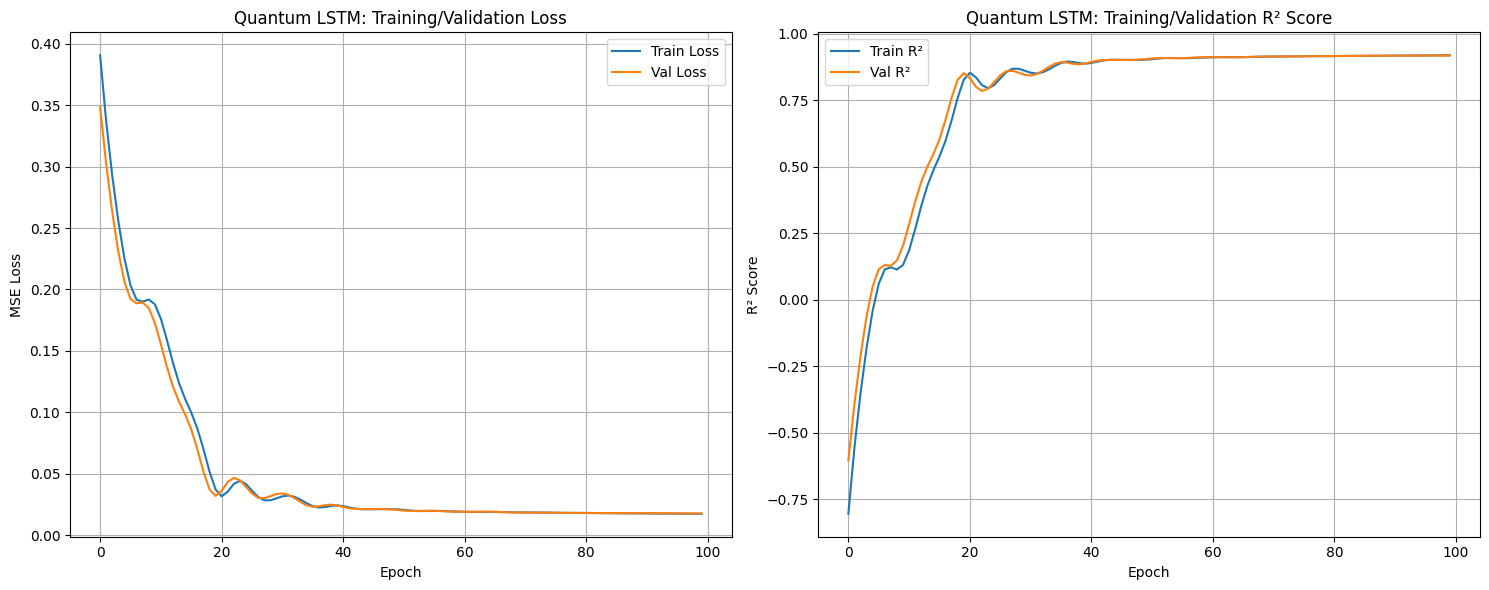

In [14]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Quantum LSTM parameters
Qinput_dim = 8
Qhidden_dim = 32
Qn_qubits = 8
Qoutput_dim = 8
backend = 'default.qubit'

model = LSTMRegressor_8_dim_3_seq(Qinput_dim, Qhidden_dim, output_dim=Qoutput_dim, n_qubits=Qn_qubits, backend=backend)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

# Training loop with metrics tracking
num_epochs = 100
train_loss_history = []
val_loss_history = []
train_r2_history = []
val_r2_history = []

# Early stopping setup
best_val_r2 = float('-inf')
patience = 20
patience_counter = 0
best_model_state = None

# Convert tensors to numpy for metric calculations
y_train_np = y_train_tensor.numpy()
y_test_np = y_test_tensor.numpy()

for epoch in range(num_epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    train_loss = loss_function(outputs[:, temp_c_index], y_train_tensor[:, temp_c_index])

    # Calculate training R²
    train_preds = outputs.detach().numpy()
    train_r2 = r2_score(y_train_np[:, temp_c_index], train_preds[:, temp_c_index], multioutput='uniform_average')

    train_loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = loss_function(val_outputs[:, temp_c_index], y_test_tensor[:, temp_c_index])
        val_preds = val_outputs.numpy()
        val_r2 = r2_score(y_test_np[:, temp_c_index], val_preds[:, temp_c_index], multioutput='uniform_average')

    # Store metrics
    train_loss_history.append(train_loss.item())
    val_loss_history.append(val_loss.item())
    train_r2_history.append(train_r2)
    val_r2_history.append(val_r2)

    print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {train_loss.item():.4f} | Val Loss: {val_loss.item():.4f} Train R²: {train_r2:.4f} | Val R²: {val_r2:.4f}")

    # Early stopping logic
    if val_r2 > best_val_r2:
        best_val_r2 = val_r2
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Load best model (optional)
if best_model_state:
    model.load_state_dict(best_model_state)

# Plotting
plt.figure(figsize=(15, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Quantum LSTM: Training/Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

# R² plot
plt.subplot(1, 2, 2)
plt.plot(train_r2_history, label='Train R²')
plt.plot(val_r2_history, label='Val R²')
plt.title('Quantum LSTM: Training/Validation R² Score')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

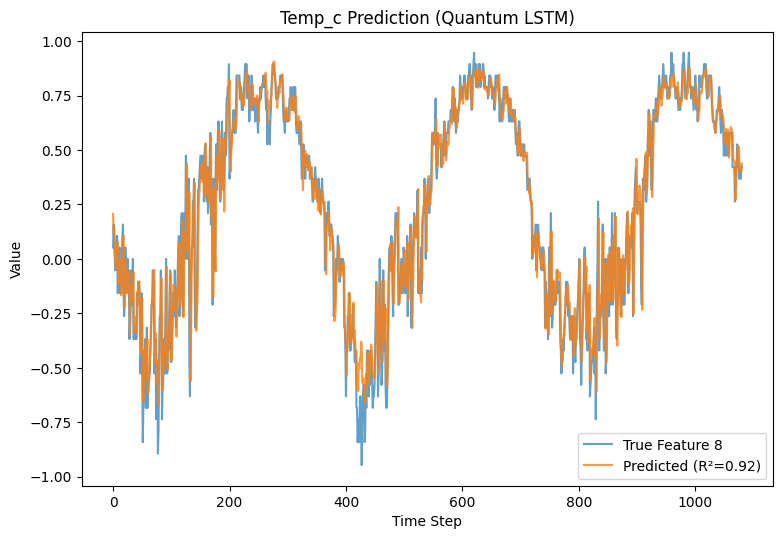


Quantum LSTM - Final Feature-wise Performance:
Temp_c :
  R²   = 0.9186
  MSE  = 6.3846
  MAE  = 1.7569
  RMSE = 2.5268
------------------------------


In [15]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Final feature-wise evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

# R² scores for each feature
feature_r2_scores = [r2_score(y_8_test[:, i], y_pred[:, i]) for i in range(8)]

# Assuming you used the same scaler for both y_train and y_test
y_8_test_rescaled = scaler.inverse_transform(y_8_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Assuming you have rescaled versions: y_8_test_rescaled and y_pred_rescaled
feature_mse = [mean_squared_error(y_8_test_rescaled[:, i], y_pred_rescaled[:, i]) for i in range(8)]
feature_mae = [mean_absolute_error(y_8_test_rescaled[:, i], y_pred_rescaled[:, i]) for i in range(8)]
feature_rmse = [np.sqrt(mean_squared_error(y_8_test_rescaled[:, i], y_pred_rescaled[:, i])) for i in range(8)]
# Plot predictions with individual R² scores
plt.figure(figsize=(15, 20))
for i in range(8):
    if i != temp_c_index:
        continue
    else:
        plt.subplot(4, 2, i+1)
        plt.plot(y_8_test[:, i], label=f'True Feature {i+1}', alpha=0.7)
        plt.plot(y_pred[:, i], label=f'Predicted (R²={feature_r2_scores[i]:.2f})', alpha=0.8)
        plt.title(f'Temp_c Prediction (Quantum LSTM)')
        plt.xlabel('Time Step')
        plt.ylabel('Value')
        plt.legend()

plt.tight_layout()
plt.show()

# Print final feature metrics
print("\nQuantum LSTM - Final Feature-wise Performance:")
i=7
print(f"Temp_c :")
print(f"  R²   = {feature_r2_scores[i]:.4f}")

print(f"  MSE  = {feature_mse[i]:.4f}")
print(f"  MAE  = {feature_mae[i]:.4f}")
print(f"  RMSE = {feature_rmse[i]:.4f}")
print("-" * 30)

In [16]:
# Function to calculate total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example: Assuming `model` is your PyTorch model
num_parameters = count_parameters(model)

print(f"The model has {num_parameters} trainable parameters.")

The model has 880 trainable parameters.


In [17]:
# Function to count total trainable parameters and list each parameter name with its count
def count_and_list_parameters(model):
    total_params = 0
    print("Trainable Parameters:\n" + "-"*30)
    for name, param in model.named_parameters():
        if param.requires_grad:
            param_count = param.numel()
            total_params += param_count
            print(f"{name:50} → {param_count}")
    print("-"*30)
    print(f"Total classical trainable parameters: {total_params:,}")
    return total_params

# Example: Assuming `zzfeatuermapQLSTM` is your PyTorch model
classical_parameter=count_and_list_parameters(model)
print("-"*30)
print("All Parameters (Trainable + Non-Trainable):")
for name, param in model.named_parameters():
    print(f"{name:40} → shape = {tuple(param.shape)} | requires_grad = {param.requires_grad}")


Trainable Parameters:
------------------------------
lstm.clayer_in.weight                              → 320
lstm.clayer_in.bias                                → 8
lstm.clayer_out.weight                             → 256
lstm.clayer_out.bias                               → 32
fc.weight                                          → 256
fc.bias                                            → 8
------------------------------
Total classical trainable parameters: 880
------------------------------
All Parameters (Trainable + Non-Trainable):
lstm.clayer_in.weight                    → shape = (8, 40) | requires_grad = True
lstm.clayer_in.bias                      → shape = (8,) | requires_grad = True
lstm.clayer_out.weight                   → shape = (32, 8) | requires_grad = True
lstm.clayer_out.bias                     → shape = (32,) | requires_grad = True
fc.weight                                → shape = (8, 32) | requires_grad = True
fc.bias                                  → shape = (8,) |

In [18]:
quantum_params = sum(p.numel() for gate in model.lstm.VQC.values() for p in gate.parameters())
print(f"\nTotal quantum parameters: {quantum_params}")



Total quantum parameters: 32


In [19]:
print("\nTotal parameters in model (including quantum):", classical_parameter + quantum_params)


Total parameters in model (including quantum): 912


In [27]:
torch.save(model.state_dict(), "quantum_model_weights.pth")


In [21]:
import numpy as np
import torch

def iterative_forecast_map(model, x_test, days_to_predict, scaler, device="cpu"):
    if isinstance(x_test, torch.Tensor):  # Ensure x_test is a NumPy array
        x_test = x_test.to(device).detach().numpy()

    n_samples, seq_len, n_features = x_test.shape
    prediction_dict = {}

    for step in range(1, days_to_predict + 1):
        predictions = []  # Store predictions for this step
        for i in range(n_samples - step + 1):
            # Get the initial sequence for the current sample
            sequence = torch.tensor(x_test[i], dtype=torch.float32, device=device).unsqueeze(0)  # Add batch dim

            # Use `seq_len - step` actual values and the remaining from predictions
            for t in range(step - 1):
                prediction = model(sequence)  # Forward pass instead of predict()
                prediction = prediction.squeeze(0).detach().cpu().numpy()  # Convert back to NumPy
                sequence = np.vstack((sequence.squeeze(0).cpu().numpy()[1:], prediction))  # Update sequence
                sequence = torch.tensor(sequence, dtype=torch.float32, device=device).unsqueeze(0)  # Convert back

            # Final prediction for the current step
            final_prediction = model(sequence).detach().cpu().numpy()
            predictions.append(final_prediction[0])

        # Convert predictions to array and inverse transform
        predictions = scaler.inverse_transform(np.array(predictions))

        # Store in dictionary with correct slicing
        prediction_dict[step] = predictions.reshape(-1, 1, n_features)

    return prediction_dict

In [22]:
optimize_predictions_10 = iterative_forecast_map(model, X_test_tensor, 4, scaler)
optimize_predictions_10

{1: array([[[ 31.96404  ,  49.263367 , 175.25453  , ...,   2.6029847,
           79.23396  ,  32.916847 ]],
 
        [[ 31.557165 ,  49.09679  , 175.18341  , ...,   2.543748 ,
           78.97434  ,  31.263865 ]],
 
        [[ 31.609898 ,  49.05032  , 175.60202  , ...,   2.5560338,
           79.054146 ,  31.742481 ]],
 
        ...,
 
        [[ 32.96137  ,  50.036266 , 173.77052  , ...,   2.766162 ,
           79.86388  ,  36.73315  ]],
 
        [[ 32.92224  ,  50.008232 , 173.9278   , ...,   2.7608764,
           79.84282  ,  36.587463 ]],
 
        [[ 33.084732 ,  50.208233 , 173.7635   , ...,   2.796215 ,
           79.95717  ,  37.321228 ]]], dtype=float32),
 2: array([[[ 30.987955 ,  48.907856 , 174.56523  , ...,   2.438906 ,
           78.55355  ,  28.613441 ]],
 
        [[ 30.672646 ,  48.80521  , 174.59431  , ...,   2.4005804,
           78.385544 ,  27.532125 ]],
 
        [[ 30.760994 ,  48.7974   , 174.70436  , ...,   2.411291 ,
           78.443596 ,  27.885468 ]],
 
 

In [28]:
import pickle
# Save prediction_dict to a file
with open('prediction_dict.pkl', 'wb') as file:
    pickle.dump(optimize_predictions_10, file)

print("prediction_dict saved successfully.")

prediction_dict saved successfully.


prediction num 1

Precision: 0.87
Recall: 0.54
F1 Score: 0.67


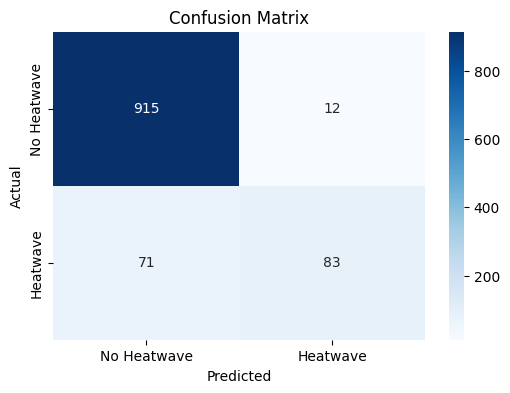

prediction num 2

Precision: 0.00
Recall: 0.00
F1 Score: 0.00


c:\Users\muham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


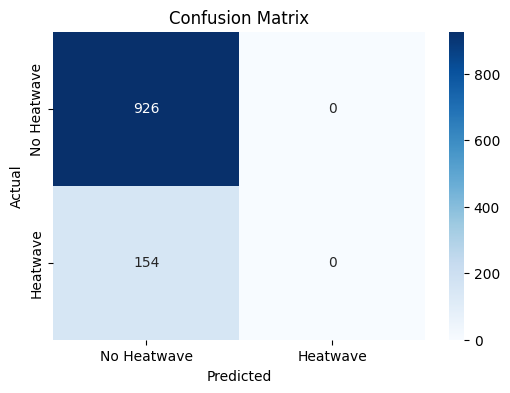

prediction num 3

Precision: 0.00
Recall: 0.00
F1 Score: 0.00


c:\Users\muham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


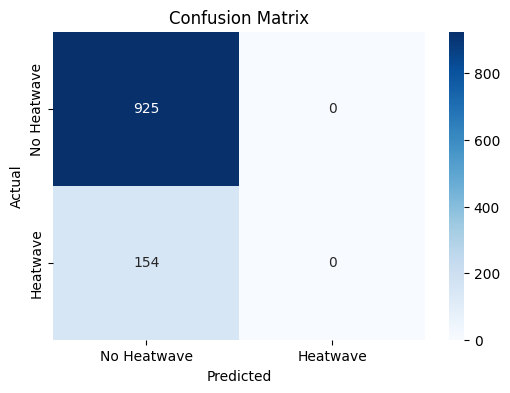

prediction num 4

Precision: 0.00
Recall: 0.00
F1 Score: 0.00


c:\Users\muham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


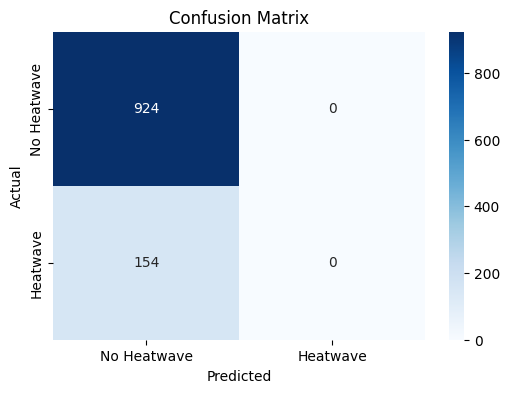

In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

threshold = np.percentile(daily_max_temp["temp_c"], 90)

# Function to classify each day based on specified criteria
def classify_heatwave(data, threshold):
    # Convert data to NumPy array if it's a DataFrame or Series
    if isinstance(data, (pd.DataFrame, pd.Series)):
        data = data.values
    heatwave = [0] * len(data)  # Initialize the heatwave list with zeros
    for i in range(2, len(data)):
        if data[i] >= threshold:
            if data[i-1] >= threshold and data[i-2] >= threshold:
                heatwave[i] = 1
                heatwave[i-1] = 1
                heatwave[i-2] = 1
            else:
                heatwave[i] = 0
        else:
            heatwave[i] = 0
    return heatwave

# Example actual values (replace with your actual data)
actual_values = pd.DataFrame(y_8_test_rescaled).copy()
predictions=optimize_predictions_10
# Example prediction_dict (replace with your actual prediction_dict)
prediction_dict = optimize_predictions_10

# Initialize lists to store results
all_Precision = []
all_recall = []
all_f1score = []

# Loop through each horizon in prediction_dict
for step in range(1, len(prediction_dict) + 1):
    print(f"prediction num {step}\n")
    
    # Get predictions for the current horizon
    prediction = pd.DataFrame(predictions[step].reshape(len(actual_values) - (step - 1), 8))
    
    # Slice actual values to align with predictions
    temperory_actual_values = actual_values.iloc[step - 1:].copy()
    
    # Classify heatwave for actual values
    actual_heatwave_flags = classify_heatwave(temperory_actual_values[temp_c_index], threshold)
    temperory_actual_values["day_included_heatwave"] = actual_heatwave_flags
    
    # Classify heatwave for predicted values
    prediction_values_heatwave_flags = classify_heatwave(prediction[temp_c_index], threshold)
    prediction["day_included_heatwave"] = prediction_values_heatwave_flags
    
    # Extract heatwave columns
    y_true = temperory_actual_values['day_included_heatwave']
    y_pred = prediction['day_included_heatwave']
    
    # Compute evaluation metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    # Append metrics to lists
    all_Precision.append(precision)
    all_recall.append(recall)
    all_f1score.append(f1)
    
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heatwave', 'Heatwave'], yticklabels=['No Heatwave', 'Heatwave'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

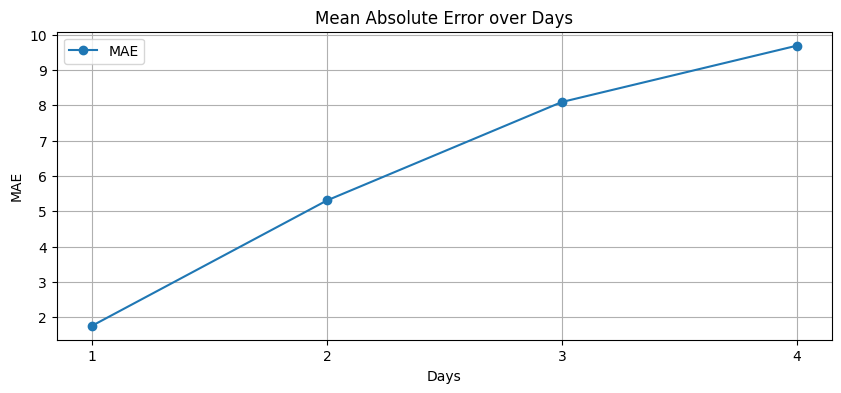

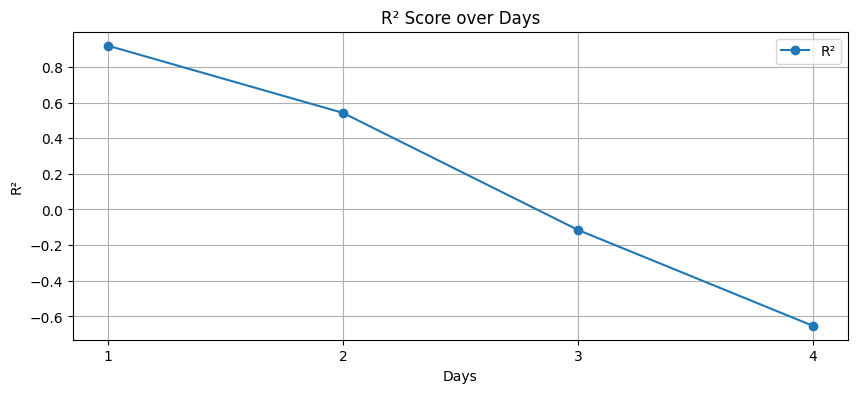

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

prediction_dict = predictions
actual_values = pd.DataFrame(y_8_test_rescaled).copy()

# Initialize lists to store metrics
all_mae = []
all_r2 = []

# Loop through each horizon in prediction_dict
for step in range(1, len(prediction_dict) + 1):    
    # Get predictions for the current horizon
    prediction = pd.DataFrame(predictions[step].reshape(len(actual_values) - (step - 1), 8))
    
    # Slice actual values to align with predictions
    temperory_actual_values = actual_values.iloc[step - 1:].copy()
    
    # Extract actual and predicted temperature values
    y_true = temperory_actual_values[temp_c_index]
    y_pred = prediction[temp_c_index]
    
    # Compute evaluation metrics
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Append metrics to lists
    all_mae.append(mae)
    all_r2.append(r2)
    

# Plot MAE over days
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(all_mae) + 1), all_mae, label='MAE', marker='o')
plt.xlabel("Days")
plt.ylabel("MAE")
plt.title("Mean Absolute Error over Days")
plt.legend()
plt.grid(True)
plt.xticks(range(1, len(all_mae) + 1))  # Set x-axis ticks to be integer days
plt.show()

# Plot R² over days
plt.figure(figsize=(10, 4))
plt.plot(range(1, len(all_r2) + 1), all_r2, label='R²', marker='o')
plt.xlabel("Days")
plt.ylabel("R²")
plt.title("R² Score over Days")
plt.legend()
plt.grid(True)
plt.xticks(range(1, len(all_r2) + 1))  # Set x-axis ticks to be integer days
plt.show()
